In [ ]:
#!pip install pycbc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 1.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import constants
from scipy import signal
import scipy.integrate as integrate
import scipy.special as special
from scipy.integrate import dblquad
from matplotlib.ticker import MultipleLocator
import pylab
import astropy.units as u
from astropy.constants import G, c
from astropy.cosmology import FlatLambdaCDM, z_at_value
from scipy.special import gamma as gamma_func
from matplotlib.colors import LogNorm

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import constants
from scipy import signal
import scipy.integrate as integrate
import scipy.special as special
from pycbc.waveform import td_approximants, fd_approximants

/usr/local/lib/python3.12/dist-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [ ]:
from pycbc.waveform import get_td_waveform
import pycbc.waveform
from pycbc.types import TimeSeries
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.psd import interpolate, inverse_spectrum_truncation
import pylab
from pycbc.filter import resample_to_delta_t, highpass
import pycbc.noise
import pycbc.psd
from pycbc.filter import matched_filter
from pycbc.filter import sigma
import pylab
from mpmath import mp

In [ ]:
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

2 CPUs


In [ ]:
import multiprocessing
import psutil
import os

# Informations détaillées sur le CPU
print(f"Cœurs physiques : {psutil.cpu_count(logical=False)}")
print(f"Cœurs logiques : {psutil.cpu_count(logical=True)}")
print(f"Multiprocessing CPU count : {multiprocessing.cpu_count()}")
print(f"OS CPU count : {os.cpu_count()}")

# Utilisation actuelle
print(f"Utilisation CPU par cœur : {psutil.cpu_percent(interval=1, percpu=True)}")

Cœurs physiques : 1
Cœurs logiques : 2
Multiprocessing CPU count : 2
OS CPU count : 2
Utilisation CPU par cœur : [3.0, 3.0]


In [ ]:
from functools import partial
import multiprocessing
from tqdm import tqdm

## MCMC in wave optic regime

In [ ]:
from pycbc.waveform import get_td_waveform
from pycbc.types import TimeSeries
import numpy as np
import pylab
import astropy.units as u
from astropy.constants import G, c
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
from pycbc.psd import aLIGOZeroDetHighPower

# Define cosmology and constants
solar_mass_kg = 1.9891e30

In [ ]:
def calculate_amplification_factor(f_gw, M_kg, dl_m, beta_rad, einstein_rad_rad):
    """
    Calculates the complex wave optics amplification factor F(f).
    """
    # Create an output array for the results, initialized to handle f=0
    # At f=0 (DC offset), there is no wave, so magnification is 1 (no change).
    F_f = np.ones_like(f_gw, dtype=complex)

    # Identify where the frequency is non-zero to avoid log(0) errors
    non_zero_freq_mask = f_gw > 0

    # Only perform calculations on the non-zero frequencies
    f_calc = f_gw[non_zero_freq_mask]

    if dl_m < (100*u.pc).to(u.m).value:
      z_l = 0
    else:
      # Use z_at_value with zmax=1.6 to get unique low-z solution
      z_l = z_at_value(cosmo.angular_diameter_distance,dl_m*(u.m), zmax = 1.6)

    # Redshifted mass is calculated using the derived z_lens
    Mz_kg = M_kg * (1 + z_l)

    # Calculate dimensionless parameters y (frequency) and w (impact parameter)
    y = (8 * np.pi * G.value * Mz_kg / (c.value**3)) * f_calc
    w = beta_rad / einstein_rad_rad
    # Calculate the phi_m phase term
    xm = (w + np.sqrt(w**2 + 4)) / 2
    phi_m = (xm - w)**2 / 2 - np.log(xm)

    # Arguments for the special functions
    gamma_arg = 1 - 1j * y / 2
    hyp1f1_a = 1j * y / 2
    hyp1f1_z = 1j * (w**2) * y / 2

    # Calculate terms that are already vectorized
    term1 = np.exp((np.pi * y / 4) + (1j * y / 2) * (np.log(y / 2) - 2*phi_m))
    term2 = gamma_func(gamma_arg)

    # --- THE DEFINITIVE FIX: Manual For Loop for hyp1f1 ---
    # Create an array to hold the results of the hyp1f1 calculation
    term3 = np.zeros_like(hyp1f1_a, dtype=complex)

    # Loop through each element and call hyp1f1 individually.
    # This is guaranteed to work even if hyp1f1 is not properly vectorized.
    for i in range(len(hyp1f1_a)):
        a_real = float(hyp1f1_a[i].real)
        a_imag = float(hyp1f1_a[i].imag)
        z_real = float(hyp1f1_z[i].real)
        z_imag = float(hyp1f1_z[i].imag)

        # Create mpmath complex numbers correctly
        a_mp = mp.mpc(a_real, a_imag)
        z_mp = mp.mpc(z_real, z_imag)

        term3[i] = complex(mp.hyp1f1(a_mp, 1, z_mp))

    # Place the calculated results into the correct positions in the output array
    F_f[non_zero_freq_mask] = term1 * term2 * term3

    return F_f

In [ ]:
def einstein_radius_nonvec(M_kg, ds_m, dl_m):
    """
    Calculate einstein radius in radians for 1 set {M,ds,dl}
    return : Einstein radius in radians
    """
    d_ls_m = ds_m- dl_m
    numerator = 4 * G.value * M_kg * d_ls_m
    denominator = (c.value ** 2) * ds_m* dl_m

    einstrad_val = np.sqrt(numerator / denominator)

    return einstrad_val # Returns Einstein radius in radians

In [ ]:
def einstein_radius_calc(M_kg, ds_m, dl_m):
    if ds_m <= dl_m: return 0
    d_ls_m = ds_m - dl_m
    einstein_rad_sq = (4 * G.value * M_kg / (c.value**2)) * (d_ls_m / (ds_m * dl_m))
    return np.sqrt(einstein_rad_sq)

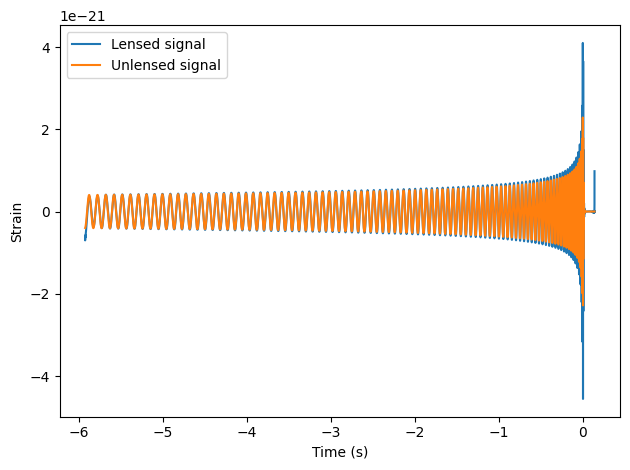

Simulated data created



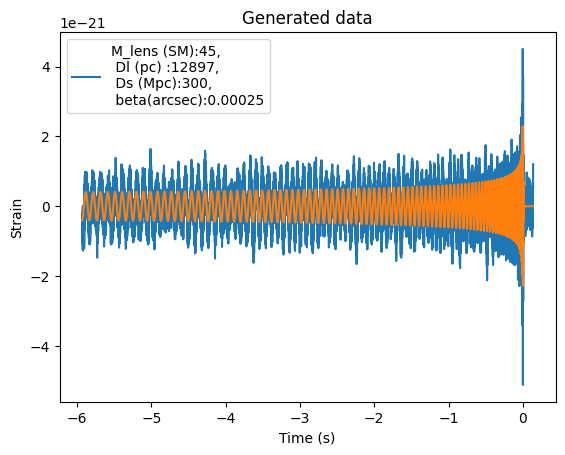

In [ ]:
# ---1. First, we create our lensed data ---

true_mass_lens = 45 #solar_masses
true_dl_pc = 12897 #pc
true_ds_pc = 300 #Mpc
true_beta_arcsec = 2.5e-4

hp_unlensed,_ = get_td_waveform(approximant='SEOBNRv3',
                         mass1=30,
                         mass2=30,
                         delta_t=1.0/4096,
                         f_lower=10,
                         distance = true_ds_pc)

delta_f = 1/hp_unlensed.duration
flen = len(hp_unlensed)//2 + 1
f_low = 10
psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

# 2. Calculate the amplification in the wave optic regime
true_mass_lens_kg = true_mass_lens*solar_mass_kg #kg
true_dl_m = (12897*u.pc).to(u.m).value #m
true_ds_m = (300e6*u.pc).to(u.m).value #m
true_beta_rad = (2.5e-4*u.arcsec).to(u.rad).value #rad

hp_unlensed_freq = hp_unlensed.to_frequencyseries()
frequency_array = np.array(hp_unlensed_freq.sample_frequencies)
true_einstein_rad = einstein_radius_calc(true_mass_lens_kg,true_ds_m,true_dl_m)
true_F_f = calculate_amplification_factor(frequency_array,true_mass_lens_kg,true_dl_m,true_beta_rad,true_einstein_rad)

# 3. Apply the magnification
hp_lensed_freq = hp_unlensed_freq * true_F_f
hp_lensed = hp_lensed_freq.to_timeseries()
hp_lensed = resample_to_delta_t(highpass(hp_lensed,10),1./4096)
pylab.figure()
pylab.plot(hp_lensed.sample_times, hp_lensed, label = 'Lensed signal')
pylab.plot(hp_unlensed.sample_times, hp_unlensed, label = 'Unlensed signal')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
pylab.tight_layout()
pylab.show()



# 4. Generate realistic noise
delta_f = 1/hp_lensed.duration
flen = len(hp_lensed)//2 + 1
f_low = 10
psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
freqs = psd.sample_frequencies
psd_data = psd.data
delta_t = 1.0 / 4096
noise_len = len(hp_lensed)
noise = pycbc.noise.noise_from_psd(noise_len, delta_t, psd, seed=150)
noise_timeseries = TimeSeries(noise, delta_t= delta_t, epoch = hp_lensed.start_time) #bruit plotté à partir de t = 0 -> need a shift in h_plus

# 5. Inject noise into the lensed signal. This is our data
data = hp_lensed + noise_timeseries

print ("Simulated data created\n")
pylab.figure()
label_string = f'M_lens (SM):{true_mass_lens},\n Dl (pc) :{true_dl_pc},\n Ds (Mpc):{true_ds_pc},\n beta(arcsec):{true_beta_arcsec}'
pylab.plot(data.sample_times, data, label =label_string)
pylab.plot(hp_unlensed.sample_times, hp_unlensed)
pylab.title('Generated data')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
pylab.show()







In [ ]:
sr = 1./hp_unlensed.duration
print (sr)

0.1647958157312412


In [ ]:
print (1/4096)

0.000244140625


In [ ]:
sr

In [ ]:
start = float(hp_unlensed.start_time)

In [ ]:
start2= float(hp_unlensed.start_time)

In [ ]:
s = int(-start*4096)+1

24286

In [ ]:
t = hp_unlensed.sample_times[s]
print (t)

3.749995869384293e-10


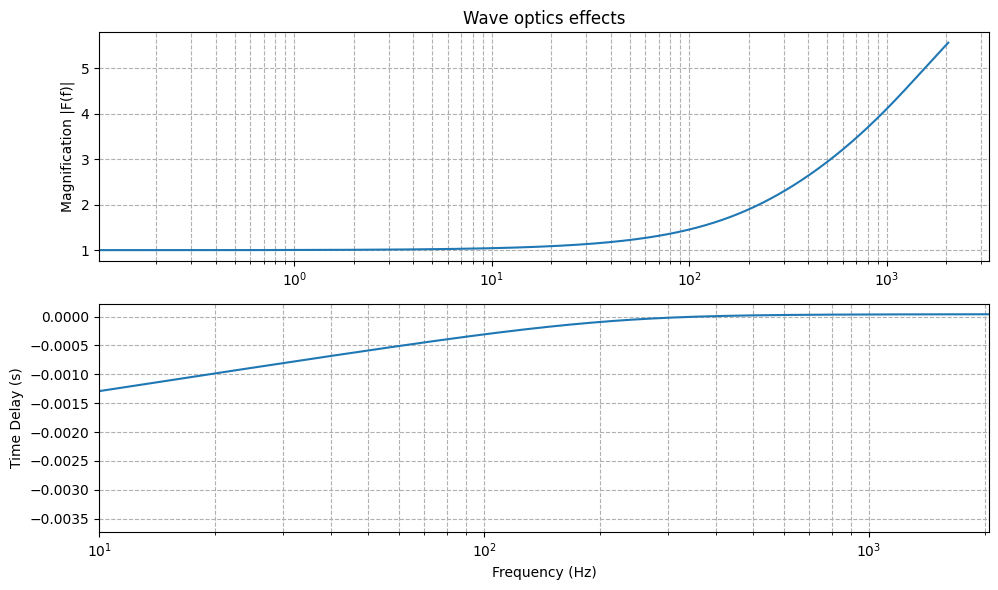

In [ ]:
from astropy import units as u
import numpy as np
import pylab

# --- Calculate and Plot the Group Delay ---
true_magnification = np.abs(true_F_f)

true_phase_f = np.unwrap(np.angle(true_F_f))


true_dphi_df = np.gradient(true_phase_f, frequency_array)


true_time_delay_f = (1 / (2 * np.pi)) * true_dphi_df

# --- Plotting the result ---
pylab.figure(figsize=[10, 6])

# Plot Magnification
pylab.subplot(2, 1, 1)
pylab.semilogx(frequency_array, true_magnification)
pylab.title("Wave optics effects")
pylab.ylabel("Magnification |F(f)|")
#pylab.xlim(10, 2048)
pylab.grid(True, which="both", ls="--")

# Plot the frequency dep time delay
pylab.subplot(2, 1, 2)
pylab.semilogx(frequency_array, true_time_delay_f)
pylab.ylabel("Time Delay (s)")
pylab.xlabel("Frequency (Hz)")
pylab.xlim(10, 2048)
pylab.grid(True, which="both", ls="--")
pylab.tight_layout()
pylab.savefig("wave_optics_effects.png")
pylab.show()



/usr/local/lib/python3.11/dist-packages/astropy/units/quantity.py:659: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/local/lib/python3.11/dist-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


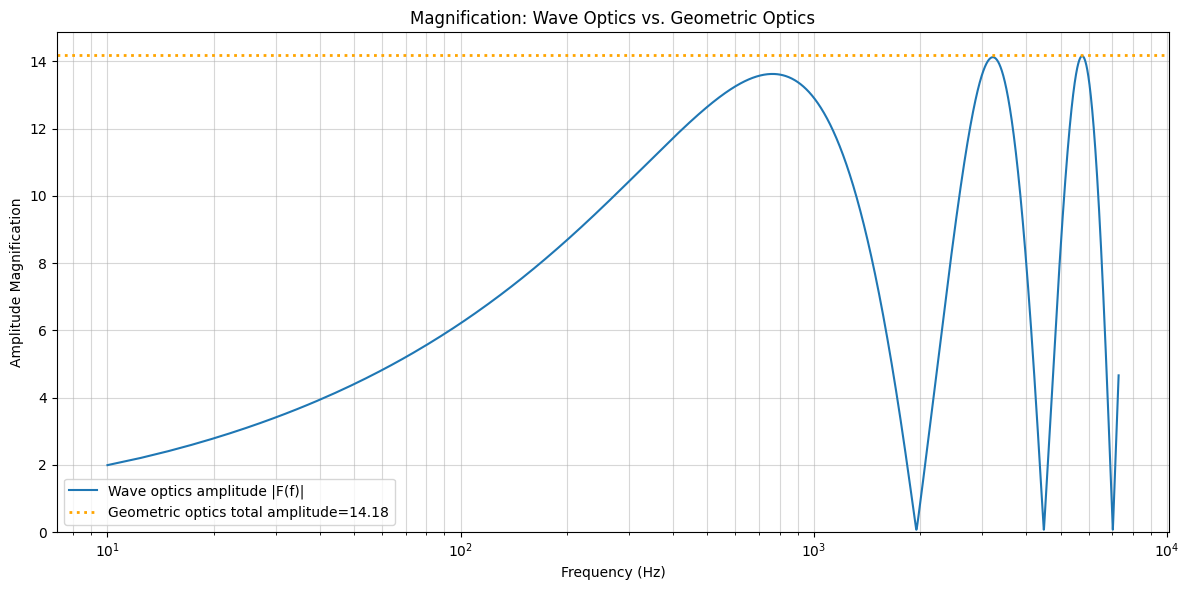

In [ ]:
def geometric_optics_model(z_l, dl_m, ds_m, M_kg, beta_rad):
    """
    Calculates the key observables for geometric optics: individual magnifications
    and the time delay difference between the two images.
    """
    d_ls_m = ds_m - dl_m
    if d_ls_m <= 0:
        return 0, 0, 0, 0

    einstein_rad_sq = (4 * G.value * M_kg / c.value**2) * (d_ls_m / (ds_m * dl_m))
    einstein_rad = np.sqrt(einstein_rad_sq)
    w = beta_rad / einstein_rad


    sqrt_term = np.sqrt(w**2 + 4)
    mag_plus = 0.5 * (1 + (w**2 + 2) / (w * sqrt_term))
    mag_minus = 0.5 * (1 - (w**2 + 2) / (w * sqrt_term))
    total_flux_magnification = np.abs(mag_plus) + np.abs(mag_minus)

    time_delay_const = (1 + z_l) * (4 * G.value * M_kg / c.value**3)
    term1 = (w * sqrt_term) / 2
    term2 = np.log((sqrt_term + w) / (sqrt_term - w))
    time_delay_difference = time_delay_const * (term1 + term2) #faster computation of time delay between both images- this is the same mathematics

    return mag_plus, mag_minus, total_flux_magnification, time_delay_difference


true_mass_lens = 1000 #solar_masses
true_dl_pc = 12897 #pc
true_ds_pc = 300 #Mpc
true_beta_arcsec = 2.5e-4




true_mass_lens_kg = true_mass_lens * solar_mass_kg
true_dl_m = (true_dl_pc * u.pc).to(u.m).value
true_ds_m = (true_ds_pc * 1e6 * u.pc).to(u.m).value
true_beta_rad = (true_beta_arcsec * u.arcsec).to(u.rad).value

frequency_array = np.linspace(10,1e4,4096)
true_einstein_rad = einstein_radius_nonvec(true_mass_lens_kg, true_ds_m, true_dl_m)
true_F_f = calculate_amplification_factor(frequency_array, true_mass_lens_kg, true_dl_m, true_beta_rad, true_einstein_rad)
true_magnification = np.abs(true_F_f)


z_lens = z_at_value(cosmo.angular_diameter_distance, true_dl_pc * u.pc, zmax=10)
mag_p, mag_m, mag_total_flux, dt_geom = geometric_optics_model(
    z_lens, true_dl_m, true_ds_m, true_mass_lens_kg, true_beta_rad)


mag_total_amp = np.sqrt(mag_total_flux) #amplification = sqrt(flux)


pylab.figure(figsize=[12, 6])

# Plot
pylab.semilogx(frequency_array, true_magnification, label="Wave optics amplitude |F(f)|")
pylab.axhline(np.sqrt(np.abs(mag_m)) + np.sqrt(np.abs(mag_p)), label=f"Geometric optics total amplitude={np.sqrt(np.abs(mag_m)) + np.sqrt(np.abs(mag_p)):.2f}", color="orange", ls=":", lw=2)
pylab.title("Magnification: Wave Optics vs. Geometric Optics")
pylab.xlabel("Frequency (Hz)")
pylab.ylabel("Amplitude Magnification")
pylab.legend()
pylab.ylim(bottom=0)
pylab.grid(True, which="both", ls="-", alpha=0.5)


pylab.tight_layout()
pylab.savefig("wave_optics_vs_geometric_optics.png")
pylab.show()

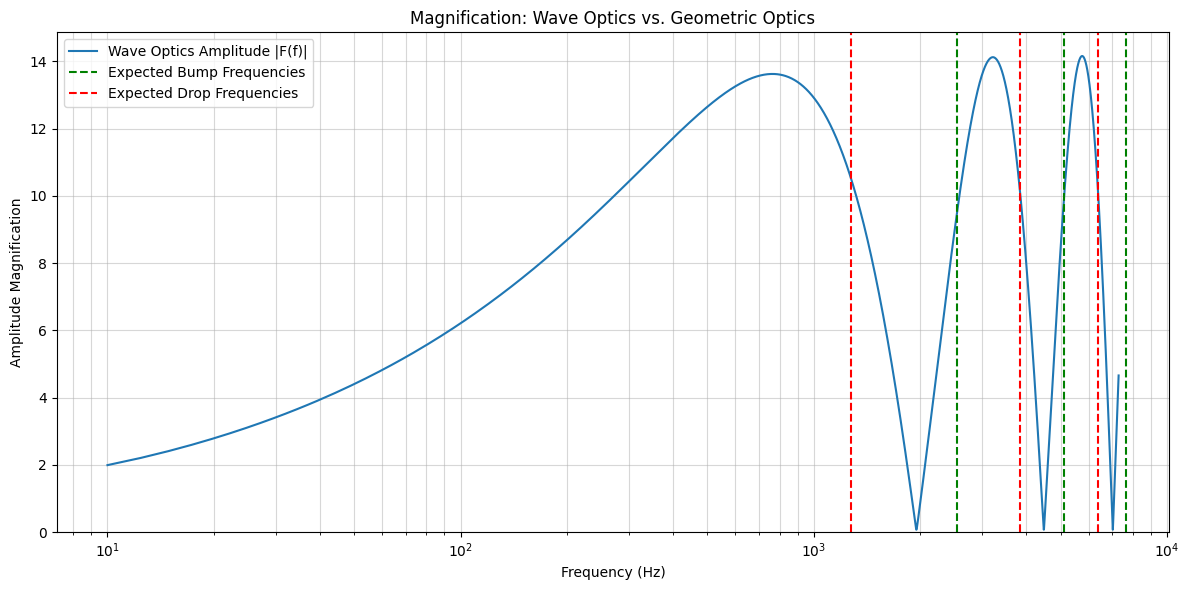

In [ ]:
pylab.figure(figsize=[12, 6])

# Plot Magnification Comparison
pylab.semilogx(frequency_array, true_magnification, label="Wave Optics Amplitude |F(f)|")
pylab.title("Magnification: Wave Optics vs. Geometric Optics")
pylab.xlabel("Frequency (Hz)")
pylab.ylabel("Amplitude Magnification")
pylab.legend()
#pylab.xlim(10, 2048)
pylab.ylim(bottom=0)
pylab.grid(True, which="both", ls="-", alpha=0.5)

# Add annotation explaining the interference
fringe_freq = 1.0 / dt_geom

pylab.axvline(fringe_freq, label=f"Expected Bump Frequencies", color="green", ls="--")
pylab.axvline(2*fringe_freq, color="green", ls="--")
pylab.axvline(3*fringe_freq, color="green", ls="--")
pylab.axvline(fringe_freq/2, label=f"Expected Drop Frequencies", color="red", ls="--")
pylab.axvline(3*fringe_freq/2, color="red", ls="--")
pylab.axvline(5*fringe_freq/2, color="red", ls="--")
pylab.legend()

pylab.tight_layout()
pylab.show()

In [ ]:
def calculate_observables_for_point(params, fixed_mass_kg, fixed_ds_m, frequency_array_template, freq_index):
    """
    Worker function to be executed in parallel.
    Calculates magnification and group delay for a single grid point.

    Args:
        params (tuple): A tuple containing (dl_pc, beta_arcsec).
        fixed_mass_kg (float): The fixed lens mass in kg.
        fixed_ds_m (float): The fixed source distance in meters.
        frequency_array_template (np.array): The array of frequencies.
        freq_index (int): The index of the target frequency.

    Returns:
        tuple: A tuple containing (magnification, group_delay).
    """
    dl_pc, beta_arcsec = params

    # Convert to SI units
    dl_m = (dl_pc * u.pc).to(u.m).value
    beta_rad = (beta_arcsec * u.arcsec).to(u.rad).value

    # Calculate Einstein radius for this point
    e_rad = einstein_radius_calc(fixed_mass_kg, fixed_ds_m, dl_m)

    if e_rad > 0:
        # Calculate the full F(f) amplification factor
        F_f = calculate_amplification_factor(frequency_array_template,
                                             fixed_mass_kg,
                                             dl_m,
                                             beta_rad,
                                             e_rad)

        # Get magnification at our chosen frequency
        magnification = np.abs(F_f[freq_index])

        # Calculate and get the group delay at our chosen frequency
        phase_f = np.unwrap(np.angle(F_f))
        dphi_df = np.gradient(phase_f, frequency_array_template)
        time_delay_f = (1 / (2 * np.pi)) * dphi_df
        group_delay = time_delay_f[freq_index]

        return (magnification, group_delay)
    else:
        # Return default values for unphysical scenarios
        return (1.0, 0.0)

/tmp/ipykernel_87/723563926.py:24: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  frequency_array = np.array(hp_unlensed_freq.sample_frequencies)


Simulated data created

Calculating true observables from injected parameters...
  -> Target Magnification at 100 Hz: 1.455
  -> Target Group Delay at 100 Hz: -0.000308 s
--- Setting up 2D Slice Analysis ---
Calculating observables at 100 Hz for 900 grid points using all available cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [22:12<00:00,  1.48s/it]


Calculation complete.

--- Filtering Grid to Find Promising MCMC Starting Points ---
Found 8 promising parameter combinations.

These parameter sets can now be used to initialize MCMC walkers:

Example of a promising point to start an MCMC:
  dl   = 10000.00 pc
  beta = 0.000 arcsec
  (ds and M were fixed at 300 Mpc and 45 M_sun)


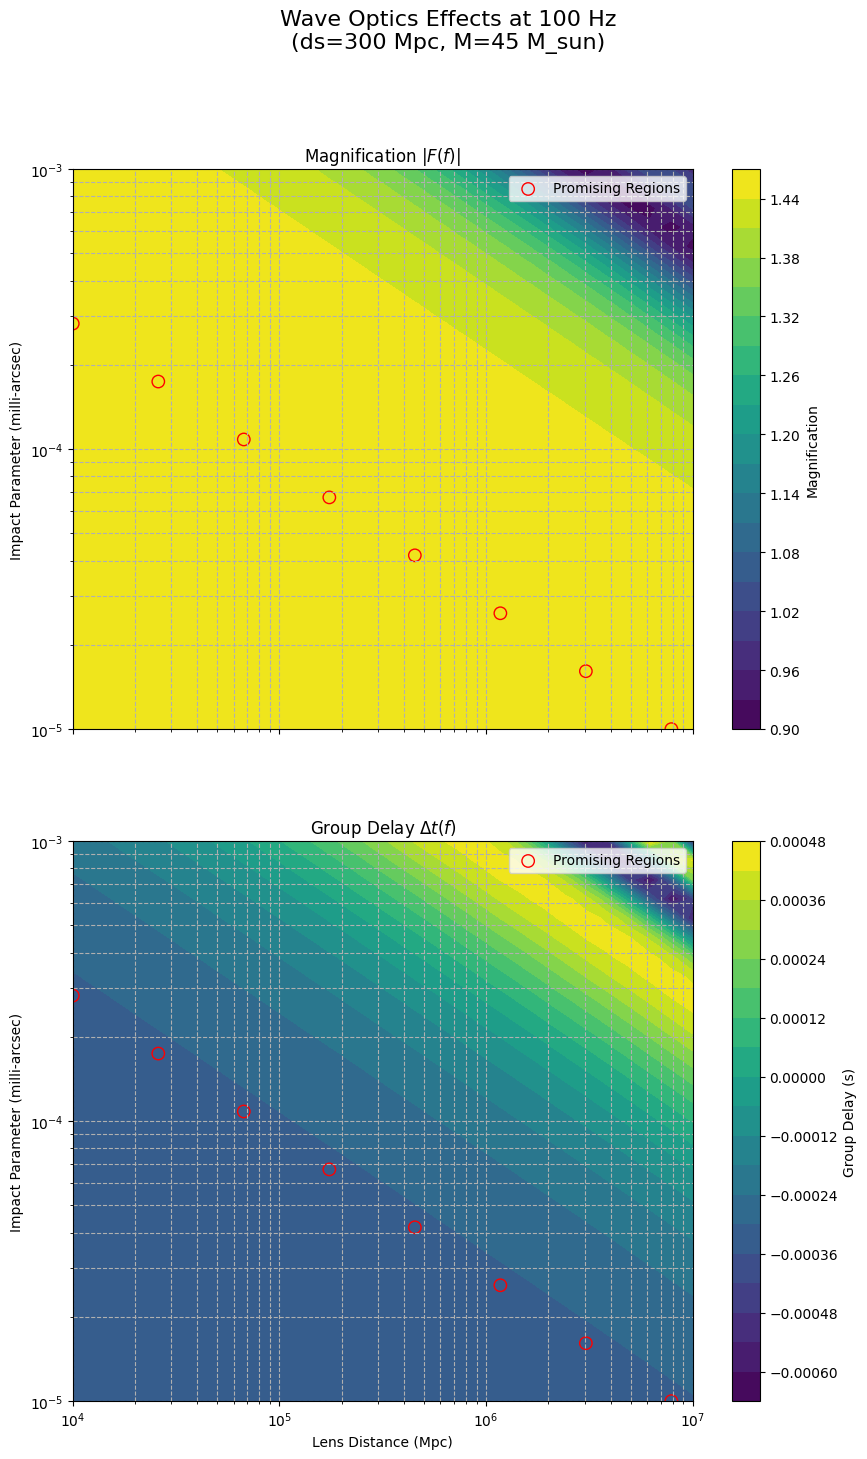

In [ ]:
if __name__ == "__main__":

    # --- DATA GENERATION ---
    true_mass_lens = 45 #solar_masses
    true_dl_pc = 12897 #pc
    true_ds_pc = 300 #Mpc
    true_beta_arcsec = 2.5e-4

    hp_unlensed,_ = get_td_waveform(approximant='SEOBNRv3',
                             mass1=30,
                             mass2=30,
                             delta_t=1.0/4096,
                             f_lower=10,
                             distance = true_ds_pc)


    # 2. Calculate the amplification in the wave optic regime
    true_mass_lens_kg = true_mass_lens*solar_mass_kg #kg
    true_dl_m = (12897*u.pc).to(u.m).value #m
    true_ds_m = (300e6*u.pc).to(u.m).value #m
    true_beta_rad = (2.5e-4*u.arcsec).to(u.rad).value #rad

    hp_unlensed_freq = hp_unlensed.to_frequencyseries()
    frequency_array = np.array(hp_unlensed_freq.sample_frequencies)
    true_einstein_rad = einstein_radius_nonvec(true_mass_lens_kg,true_ds_m,true_dl_m)
    true_F_f = calculate_amplification_factor(frequency_array,true_mass_lens_kg, true_dl_m, true_beta_rad,true_einstein_rad)

    # 3. Apply the magnification
    hp_lensed_freq = hp_unlensed_freq * true_F_f
    hp_lensed = hp_lensed_freq.to_timeseries()
    hp_lensed = resample_to_delta_t(highpass(hp_lensed,10),1./4096)


    # 4. Generate realistic noise
    delta_f = 1/hp_lensed.duration
    flen = len(hp_lensed)//2 + 1
    f_low = 10
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    freqs = psd.sample_frequencies
    psd_data = psd.data
    delta_t = 1.0 / 4096
    noise_len = len(hp_lensed)
    noise = pycbc.noise.noise_from_psd(noise_len, delta_t, psd, seed=150)
    noise_timeseries = TimeSeries(noise, delta_t= delta_t, epoch = hp_lensed.start_time) #bruit plotté à partir de t = 0 -> need a shift in h_plus

    # 5. Inject noise into the lensed signal. This is our data
    data = hp_lensed + noise_timeseries

    print ("Simulated data created\n")

    # --- 0. CALCULATE THE TRUE OBSERVABLES TO SEARCH FOR ---
    print("Calculating true observables from injected parameters...")
    # a. Define the fixed parameters
    fixed_ds_pc = true_ds_pc*1e6 # Source distance in Mpc
    fixed_lens_mass = true_mass_lens # Lens mass in Solar Masses

    #  Define the frequency array we'll use for all calculations
    freq_to_analyze = 100 # Hz
    hp_template, _ = get_td_waveform(approximant='SEOBNRv3', mass1=30, mass2=30,
                                     delta_t=1.0/4096, f_lower=10, distance=fixed_ds_pc/1e6)

    frequency_array_template = hp_template.to_frequencyseries().sample_frequencies.numpy()
    freq_index = np.argmin(np.abs(frequency_array_template - freq_to_analyze))

    target_F_f = calculate_amplification_factor(frequency_array_template,
                                                 fixed_lens_mass * solar_mass_kg,
                                                 true_dl_m,
                                                 true_beta_rad,
                                                 true_einstein_rad)

    # These are now our search targets, calculated directly from the true physics
    target_magnification = np.abs(target_F_f[freq_index])
    target_phase_f = np.unwrap(np.angle(target_F_f))
    target_dphi_df = np.gradient(target_phase_f, frequency_array_template)
    target_group_delay = (1 / (2 * np.pi)) * target_dphi_df[freq_index]


    print(f"  -> Target Magnification at {freq_to_analyze} Hz: {target_magnification:.3f}")
    print(f"  -> Target Group Delay at {freq_to_analyze} Hz: {target_group_delay:.6f} s")


    # --- 1. SETUP THE 2D SLICE ANALYSIS ---

    print("--- Setting up 2D Slice Analysis ---")

    # b. Create the 2D grid for the parameters we want to vary
    n_points = 30
    dl_pc_range = np.logspace(4, 7, n_points) # 10 kpc to 10 Mpc
    beta_arcsec_range = np.logspace(-5, -3, n_points) # 0.01 to 1 milli-arcsec


    dl_grid, beta_grid = np.meshgrid(dl_pc_range, beta_arcsec_range, indexing='ij')

     # --- 2. PARALLEL CALCULATION OF THE GRID ---
    print(f"Calculating observables at {freq_to_analyze} Hz for {n_points*n_points} grid points using all available cores...")
    fixed_ds_m = (fixed_ds_pc * u.pc).to(u.m).value
    fixed_mass_kg = fixed_lens_mass * solar_mass_kg

    # Create a list of all (dl, beta) pairs to process
    params_list = list(zip(dl_grid.flatten(), beta_grid.flatten()))

    # Use functools.partial to "freeze" the arguments of the worker function
    # that are the same for every call. This is cleaner than passing them repeatedly.
    worker_func = partial(calculate_observables_for_point,
                          fixed_mass_kg=fixed_mass_kg,
                          fixed_ds_m=fixed_ds_m,
                          frequency_array_template=frequency_array_template,
                          freq_index=freq_index)

    # Create a pool of worker processes. This will use all available cores by default.
    with multiprocessing.Pool() as pool:
        # Use starmap to apply the worker function to each parameter set in parallel
        # tqdm provides a helpful progress bar
        results = list(tqdm(pool.imap(worker_func, params_list), total=len(params_list)))

    # Unpack the results and reshape them back into a 2D grid
    magnification_results, group_delay_results = zip(*results)
    magnification_grid = np.array(magnification_results).reshape(dl_grid.shape)
    group_delay_grid = np.array(group_delay_results).reshape(dl_grid.shape)


    print("Calculation complete.")

    # --- 3. FILTER RESULTS TO FIND PROMISING PARAMETERS FOR MCMC ---
    print("\n--- Filtering Grid to Find Promising MCMC Starting Points ---")

    # a. Define your target "observed" tolerance range
    mag_tolerance = 0.02 # +/- 5%
    delay_tolerance = 0.000001 # +/- 1 microsecond

    # b. Create masks to find where the grid values fall within the target ranges
    mag_mask = np.abs(magnification_grid - target_magnification) < mag_tolerance
    delay_mask = np.abs(group_delay_grid - target_group_delay) < delay_tolerance

    # c. Combine masks to find points that satisfy BOTH conditions
    promising_indices = np.where(mag_mask & delay_mask)

    # d. Extract the dl and beta values from these promising points
    promising_dl = dl_grid[promising_indices]
    promising_beta = beta_grid[promising_indices]

    print(f"Found {len(promising_dl)} promising parameter combinations.")

    if len(promising_dl) > 0:
        print("\nThese parameter sets can now be used to initialize MCMC walkers:")
        # We now have the dl and beta. The ds and mass were fixed.
        # We can create the full parameter set for MCMC.
        promising_ds = np.full_like(promising_dl, fixed_ds_pc)
        promising_mass = np.full_like(promising_dl, fixed_lens_mass)

        # You can now use promising_dl, promising_ds, promising_mass, promising_beta
        # just as you did in your previous MCMC script.
        print("\nExample of a promising point to start an MCMC:")
        print(f"  dl   = {promising_dl[0] :.2f} pc")
        print(f"  beta = {promising_beta[0] :.3f} arcsec")
        print(f"  (ds and M were fixed at {fixed_ds_pc/1e6:.0f} Mpc and {fixed_lens_mass:.0f} M_sun)")

    # --- 4. PLOT THE 2D HEATMAPS WITH PROMISING POINTS OVERLAID ---

    fig, (ax1, ax2) = pylab.subplots(2, 1, figsize=[10, 16], sharex=True)
    fig.suptitle(f'Wave Optics Effects at {freq_to_analyze} Hz\n(ds={fixed_ds_pc/1e6:.0f} Mpc, M={fixed_lens_mass:.0f} M_sun)', fontsize=16)

    # Plot 1: Magnification
    im1 = ax1.contourf(dl_grid , beta_grid , magnification_grid, levels=20)
    fig.colorbar(im1, ax=ax1, label='Magnification')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_ylabel('Impact Parameter (milli-arcsec)')
    ax1.grid(True, which="both", ls="--")
    ax1.set_title('Magnification $|F(f)|$')

    # Plot 2: Group Delay
    im2 = ax2.contourf(dl_grid , beta_grid , group_delay_grid, levels=20)
    fig.colorbar(im2, ax=ax2, label='Group Delay (s)')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Lens Distance (Mpc)')
    ax2.set_ylabel('Impact Parameter (milli-arcsec)')
    ax2.grid(True, which="both", ls="--")
    ax2.set_title('Group Delay $\Delta t(f)$')

    # Overlay the promising points on both plots
    if len(promising_dl) > 0:
        ax1.scatter(promising_dl , promising_beta ,
                    facecolors='none', edgecolors='r', s=80, label='Promising Regions')
        ax2.scatter(promising_dl , promising_beta ,
                    facecolors='none', edgecolors='r', s=80, label='Promising Regions')
        ax1.legend()
        ax2.legend()

    pylab.show()

Actually, we can kill some degenerancies by comparing the amplitude curves, so we focus on ALL frequencies !

In [ ]:
def calculate_chi_squared_for_point(params, fixed_mass_kg, fixed_ds_m, frequency_array_template, target_F_f):
    """
    Worker function to be executed in parallel.
    Calculates chi-squared for a single grid point.
    """
    dl_pc, beta_arcsec = params
    dl_m = (dl_pc * u.pc).to(u.m).value
    beta_rad = (beta_arcsec * u.arcsec).to(u.rad).value
    e_rad = einstein_radius_calc(fixed_mass_kg, fixed_ds_m, dl_m)

    if e_rad > 0:
        F_f_template = calculate_amplification_factor(frequency_array_template,
                                                     fixed_mass_kg,
                                                     dl_m,
                                                     beta_rad,
                                                     e_rad)
        chi_squared = np.sum(np.abs(F_f_template - target_F_f)**2)
        return chi_squared
    else:
        return np.nan


In [ ]:
if __name__ == "__main__":

    # --- DATA GENERATION ---
    print ("Generation of data\n")
    true_mass_lens = 45 #solar_masses
    true_dl_pc = 12897 #pc
    true_ds_pc = 300 #Mpc
    true_beta_arcsec = 2.5e-4

    hp_unlensed,_ = get_td_waveform(approximant='SEOBNRv3',
                             mass1=30,
                             mass2=30,
                             delta_t=1.0/4096,
                             f_lower=20,
                             distance = true_ds_pc)


    # 2. Calculate the amplification in the wave optic regime
    true_mass_lens_kg = true_mass_lens*solar_mass_kg #kg
    true_dl_m = (12897*u.pc).to(u.m).value #m
    true_ds_m = (300e6*u.pc).to(u.m).value #m
    true_beta_rad = (2.5e-4*u.arcsec).to(u.rad).value #rad

    hp_unlensed_freq = hp_unlensed.to_frequencyseries()
    frequency_array = np.array(hp_unlensed_freq.sample_frequencies)
    true_einstein_rad = einstein_radius_nonvec(true_mass_lens_kg,true_ds_m,true_dl_m)
    true_F_f = calculate_amplification_factor(frequency_array,true_mass_lens_kg, true_dl_m,true_beta_rad,true_einstein_rad)

    # 3. Apply the magnification
    hp_lensed_freq = hp_unlensed_freq * true_F_f
    hp_lensed = hp_lensed_freq.to_timeseries()
    hp_lensed = resample_to_delta_t(highpass(hp_lensed,10),1./4096)


    # 4. Generate realistic noise
    delta_f = 1/hp_lensed.duration
    flen = len(hp_lensed)//2 + 1
    f_low = 10
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    freqs = psd.sample_frequencies
    psd_data = psd.data
    delta_t = 1.0 / 4096
    noise_len = len(hp_lensed)
    noise = pycbc.noise.noise_from_psd(noise_len, delta_t, psd, seed=150)
    noise_timeseries = TimeSeries(noise, delta_t= delta_t, epoch = hp_lensed.start_time) #bruit plotté à partir de t = 0 -> need a shift in h_plus

    # 5. Inject noise into the lensed signal. This is our data
    data = hp_lensed + noise_timeseries

    print ("Simulated data created\n")

    # --- 0. CALCULATE THE TRUE OBSERVABLES TO SEARCH FOR ---
    print("Calculating true observables from injected parameters...")
    # a. Define the fixed parameters
    fixed_ds_pc = true_ds_pc*1e6 # Source distance in Mpc
    #fixed_lens_mass = true_mass_lens # Lens mass in Solar Masses
    #fixed_dl_pc = true_dl_pc # Lens distance in pc
    fixed_beta_arcsec = true_beta_arcsec # Impact parameter in arcsec

    #  Define the frequency array we'll use for all calculations
    hp_template, _ = get_td_waveform(approximant='SEOBNRv3', mass1=30, mass2=30,
                                     delta_t=1.0/4096, f_lower=20, distance=fixed_ds_pc/1e6)

    frequency_array_template = hp_template.to_frequencyseries().sample_frequencies.numpy()
    target_F_f = calculate_amplification_factor(frequency_array_template,
                                                 fixed_lens_mass * solar_mass_kg,
                                                 true_dl_m,
                                                 true_beta_rad,
                                                 true_einstein_rad)

    # These are now our search targets, calculated directly from the true physics
    #We don't focus on the dt or group delay or magnification, we directly compare the F_f curves as it contains the amplification AND the phase


    # --- 1. SETUP THE 2D SLICE ANALYSIS ---

    print("--- Setting up 2D Slice Analysis ---")

    # b. Create the 2D grid for the parameters we want to vary
    n_points = 30
    #dl_pc_range = np.logspace(4, 5, n_points) # 10 kpc to 10 Mpc
    dl_pc_range = np.linspace(10000, 15000, n_points) # 10 kpc to 10 Mpc
    #beta_arcsec_range = np.logspace(-5, -3, n_points) # 0.01 to 1 milli-arcsec
    beta_arcsec_range = np.linspace(0,100, n_points) # 0.01 to 1 milli-arcsec



    dl_grid, beta_grid = np.meshgrid(dl_pc_range, beta_arcsec_range, indexing='ij')

    # c. Create an empty grid to store the results
    # We will calculate the chi_squared between all magnification curves
    chi_squared_grid = np.zeros_like(dl_grid)




    # --- 2. PARALLEL CALCULATION OF THE GRID ---
    print(f"Calculating chi-squared for {n_points*n_points} grid points using 18 cores...")
    fixed_ds_m = (fixed_ds_pc * u.pc).to(u.m).value
    fixed_mass_kg = (beta_arcsec_range*u.arcsec).to(u.rad) #fixed_lens_mass * solar_mass_kg
    params_list = list(zip(dl_grid.flatten(), beta_grid.flatten()))

    worker_func = partial(calculate_chi_squared_for_point,
                          fixed_mass_kg=fixed_mass_kg,
                          fixed_ds_m=fixed_ds_m,
                          frequency_array_template=frequency_array_template,
                          target_F_f=target_F_f)

    with multiprocessing.Pool(processes=18) as pool:
        results = list(tqdm(pool.imap(worker_func, params_list), total=len(params_list)))

    chi_squared_grid = np.array(results).reshape(dl_grid.shape)
    print("Calculation complete.\n")

    # --- 5. FILTER RESULTS TO FIND PROMISING PARAMETERS FOR MCMC ---
    print("\n--- Filtering Grid to Find Promising MCMC Starting Points ---")

    # a. Define chi_squared tolerance range
    chi_squared_tolerance = np.nanmin(chi_squared_grid) #

    # b. Create masks to find where the grid values fall within the target ranges ==> We will have chi_squared~0
    chi_squared_mask = chi_squared_grid == chi_squared_tolerance

    # c. Combine masks to find points that satisfy chi_squared condition
    promising_indices = np.where(chi_squared_mask)

    # d. Extract the dl and beta values from these promising points
    promising_dl = dl_grid[promising_indices]
    promising_beta = beta_grid[promising_indices]

    print(f"Found {len(promising_dl)} promising parameter combinations.")




Generation of data

Simulated data created

Calculating true observables from injected parameters...
--- Setting up 2D Slice Analysis ---
Calculating chi-squared for 900 grid points using 18 cores...


  0%|          | 0/900 [00:00<?, ?it/s]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

I will use directly true matchfilter to account for timedelay for comparison -> This is more robust

In [ ]:
from matplotlib.ticker import LogLocator, LogFormatter

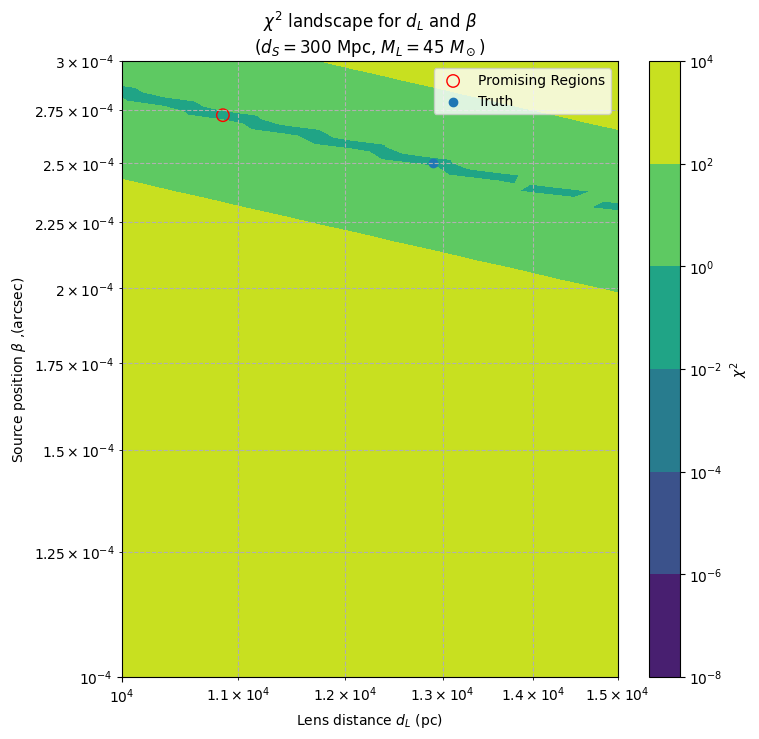

In [ ]:
    # --- 4. PLOT THE 2D HEATMAPS WITH PROMISING POINTS OVERLAID ---

    fig, ax = pylab.subplots(figsize=[8, 8])

    # Plot
    im2 = pylab.contourf(dl_grid , beta_grid , chi_squared_grid, levels=20, norm = LogNorm())
    fig.colorbar(im2, ax=ax, label='$\\chi^2$')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Lens distance $d_L$ (pc)')
    ax.set_ylabel('Source position $\\beta$ ,(arcsec)')
    pylab.grid(True, which="both", ls="--")
    title_str = (f'$\\chi^2$ landscape for $d_L$ and $\\beta$\n'
                 f'($d_S={fixed_ds_pc/1e6:.0f}$ Mpc, $M_L={fixed_lens_mass:.0f}$ $M_\\odot$)')
    ax.set_title(title_str)


    # Overlay the promising points on both plots
    if len(promising_dl) > 0:

        ax.scatter(promising_dl , promising_beta ,
                    facecolors='none', edgecolors='r', s=80, label='Promising Regions')
        ax.scatter(true_dl_pc, true_beta_arcsec, label = 'Truth')
        ax.legend()

    pylab.savefig('chi_squared_landscape.png')

    pylab.show()

NOISE

In [ ]:
def calculate_chi_squared_for_point(params, fixed_mass_kg, fixed_ds_m, hp_unlensed_freq_template, data_freq, new_psd):
    """
    Worker function to be executed in parallel.
    Calculates the noise-weighted chi-squared for a single grid point.
    """
    dl_pc, beta_arcsec = params
    dl_m = (dl_pc * u.pc).to(u.m).value

    if dl_m >= fixed_ds_m:  # Lens cannot be beyond source
        return np.nan

    beta_rad = (beta_arcsec * u.arcsec).to(u.rad).value
    e_rad = einstein_radius_calc(fixed_mass_kg, fixed_ds_m, dl_m)
    frequency_array = np.array(hp_unlensed_freq_template.sample_frequencies)

    if e_rad > 0:
        try:

            # Calculate the template amplification factor
            F_f_template = calculate_amplification_factor(frequency_array,
                                                         fixed_mass_kg, dl_m,
                                                         beta_rad, e_rad)

            # Create the ALIGNED lensed template waveform in the frequency domain
            h_lensed_template_freq = hp_unlensed_freq_template * F_f_template

            data_timeseries = data_freq.to_timeseries()
            start_d = float(data_timeseries.start_time)
            s_d = int(-start_d*4096)+1
            max_time_data = data_timeseries.sample_times[s_d]

            template_timeseries = h_lensed_template_freq.to_timeseries()
            start = float(template_timeseries.start_time)
            s = int(-start*4096)+1
            max_time_template = template_timeseries.sample_times[s]

            time_shift = max_time_data - max_time_template
            h_lensed_template = h_lensed_template_freq.cyclic_time_shift(time_shift)



            # Ensure frequency series are compatible for subtraction
            h_lensed_template = FrequencySeries(
                    h_lensed_template.data,
                    delta_f=data_freq.delta_f,  # Force same delta_f
                    epoch=hp_unlensed_freq_template.epoch
                )

            snr_series = matched_filter(
                h_lensed_template,
                data_freq,
                psd=new_psd,
                low_frequency_cutoff=20,
                high_frequency_cutoff=1024
            )
            snr_times = snr_series.sample_times.numpy()
            time_window = 0.1  # seconds
            window_mask = np.abs(snr_times) < time_window
            snr_array = np.array(snr_series)
            snr_in_window = np.abs(snr_series.data[window_mask])
            if len(snr_in_window) == 0:
                return np.nan
            max_snr_in_window = np.max(snr_in_window)







            '''

            # Calculate the noise-weighted inner product (chi-squared)
            #complex_difference = data_freq - h_lensed_template
            freqs = data_freq.sample_frequencies.numpy()
            valid_indices = (new_psd > 0) & (freqs >= 20) & (freqs <= 1024)

            #integrand = (np.abs(complex_difference[valid_indices])**2) / new_psd[valid_indices]
            #chi_squared = 4 * data_freq.delta_f * np.sum(integrand)
            h_array = h_lensed_template.numpy()[valid_indices]
            d_array = data_freq.numpy()[valid_indices]
            psd_array = new_psd.numpy()[valid_indices]

            # Normalization factor for inner product
            norm_factor = 4 * data_freq.delta_f

            # Calculate the inner products required for chi-squared
            # <h|h>
            hh = norm_factor * np.sum(np.abs(h_array)**2 / psd_array)
            # <d|d>
            dd = norm_factor * np.sum(np.abs(d_array)**2 / psd_array)
            # <d|h>
            dh = norm_factor * np.sum(d_array * np.conj(h_array) / psd_array)

            # If template has no power, cannot compute chi-squared
            if hh.real <= 0:
                return np.nan

            # Calculate the chi-squared marginalized over amplitude: chi^2 = <d|d> - |<d|h>|^2/<h|h>
            chi_squared = dd.real - (np.abs(dh)**2 / hh.real)

            if not np.isfinite(chi_squared) or chi_squared < 0:
                    return np.nan

            '''

            #return snr_array
            return max_snr_in_window

        except Exception as e:
            # Catch any unexpected errors
            print(f"Error at dl={dl_pc}, beta={beta_arcsec}: {e}")
            return np.nan

    else:
        return np.nan


In [ ]:
from pycbc.psd import welch


Optimal SNR of the injected signal: 182.35

Simulated data created

Calculating true observables from injected parameters...
--- Setting up 2D Slice Analysis ---
Calculating chi-squared for 100 grid points using 18 cores...


100%|██████████| 100/100 [00:25<00:00,  3.85it/s]


Calculation complete.


--- Filtering Grid to Find Promising MCMC Starting Points ---
Max SNR value: 176.584636
Found 1 promising parameter combinations.

These parameter sets can now be used to initialize MCMC walkers:

Top 10 best parameter combinations:
  1. dl = 10000.00 pc, beta = 1.00e-04 arcsec, chi² = 176.584636

Best point to start MCMC:
  dl   = 10000.00 pc
  beta = 1.00e-04 arcsec
  ds   = 300 Mpc (fixed)
  M    = 45 M_sun (fixed)
  chi² = 176.584636


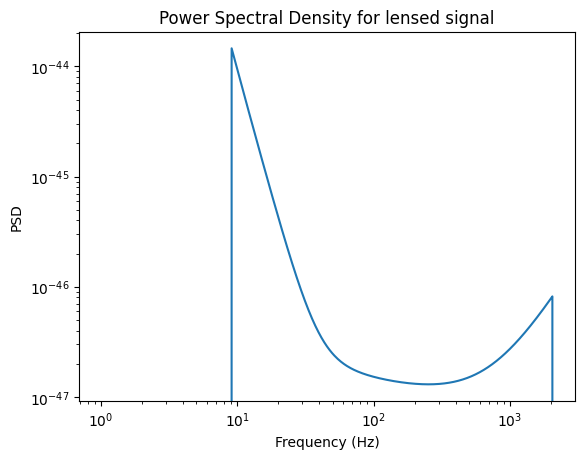

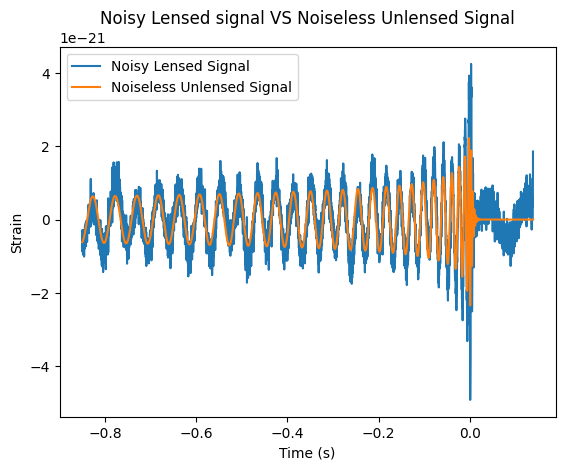

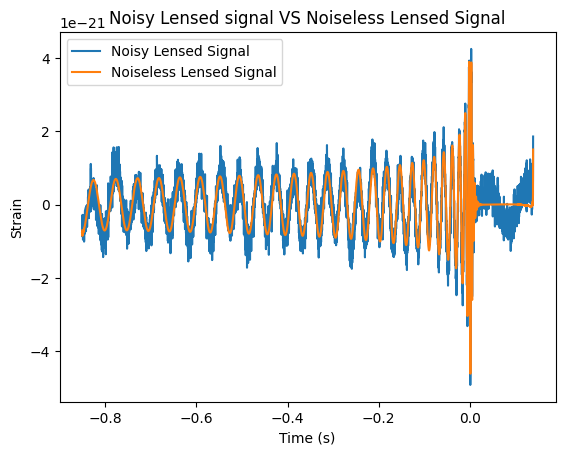

In [ ]:
if __name__ == "__main__":

    # ---1. First, we create our lensed data ---

    true_mass_lens = 45 #solar_masses
    true_dl_pc = 12897 #pc
    true_ds_pc = 300 #Mpc
    true_beta_arcsec = 2.5e-4

    hp_unlensed,_ = get_td_waveform(approximant='SEOBNRv3',
                             mass1=30,
                             mass2=30,
                             delta_t=1.0/4096,
                             f_lower=20,
                             distance = true_ds_pc)


    # 2. Calculate the amplification in the wave optic regime
    true_mass_lens_kg = true_mass_lens*solar_mass_kg #kg
    true_dl_m = (12897*u.pc).to(u.m).value #m
    true_ds_m = (300e6*u.pc).to(u.m).value #m
    true_beta_rad = (2.5e-4*u.arcsec).to(u.rad).value #rad

    hp_unlensed_freq = hp_unlensed.to_frequencyseries()
    frequency_array_template = np.array(hp_unlensed_freq.sample_frequencies)
    true_einstein_rad = einstein_radius_calc(true_mass_lens_kg,true_ds_m,true_dl_m)
    true_F_f = calculate_amplification_factor(frequency_array_template,true_mass_lens_kg,true_dl_m,true_beta_rad,true_einstein_rad)

    # 3. Apply the magnification
    hp_lensed_freq = hp_unlensed_freq * true_F_f
    hp_lensed = hp_lensed_freq.to_timeseries()
    hp_lensed = resample_to_delta_t(highpass(hp_lensed,10),1./4096)  #Warning, this induce artifacts at end end begininng but I don't think it is problematic as we'll focus at merger time
    #hp_lensed.crop(0.1,0.1)

    # 4. Generate realistic noise
    delta_f = 1/hp_lensed.duration
    flen = len(hp_lensed)//2 + 1
    f_low = 10
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    freqs = psd.sample_frequencies
    psd_data = psd.data
    delta_t = 1.0 / 4096
    noise_len = len(hp_lensed)
    noise = pycbc.noise.noise_from_psd(noise_len, delta_t, psd, seed=150)
    noise_timeseries = TimeSeries(noise, delta_t= delta_t, epoch = hp_lensed.start_time) #bruit plotté à partir de t = 0 -> need a shift in h_plus

    # 5. Inject noise into the lensed signal. This is our data
    data = hp_lensed + noise_timeseries
    pylab.figure()
    pylab.loglog(freqs,psd)
    pylab.xlabel('Frequency (Hz)')
    pylab.ylabel('PSD')
    pylab.title('Power Spectral Density for lensed signal')
    pylab.figure()
    pylab.plot(data.sample_times,data, label = "Noisy Lensed Signal")
    pylab.plot(hp_unlensed.sample_times,hp_unlensed, label = "Noiseless Unlensed Signal")
    pylab.xlabel('Time (s)')
    pylab.ylabel('Strain')
    pylab.legend()
    pylab.title('Noisy Lensed signal VS Noiseless Unlensed Signal')
    pylab.figure()
    pylab.plot(data.sample_times,data, label = "Noisy Lensed Signal")
    pylab.plot(hp_lensed.sample_times,hp_lensed, label = "Noiseless Lensed Signal")
    pylab.xlabel('Time (s)')
    pylab.ylabel('Strain')
    pylab.legend()
    pylab.title('Noisy Lensed signal VS Noiseless Lensed Signal')



    psd_data = interpolate(psd,data.to_frequencyseries().delta_f)
    psd_data.resize(len(data))
    valid_indices = psd_data > 0
    delta_f = hp_lensed_freq.delta_f

    snr_series_best = matched_filter(data,data,psd=psd_data,low_frequency_cutoff=20,high_frequency_cutoff=1024)
    snr_array_best = np.array(snr_series_best)

    max_snr_best = np.max(np.abs(snr_array_best))

    print(f"\nOptimal SNR of the injected signal: {max_snr_best:.2f}\n")

    print ("Simulated data created\n")

    # --- 0. CALCULATE THE TRUE OBSERVABLES TO SEARCH FOR ---
    print("Calculating true observables from injected parameters...")
    # a. Define the fixed parameters
    fixed_ds_pc = true_ds_pc*1e6 # Source distance in Mpc
    fixed_lens_mass = true_mass_lens # Lens mass in Solar Masses



    # Get the noisy data in the frequency domain
    hp_unlensed_template = hp_unlensed.copy()
    hp_unlensed_template.resize(len(data))
    hp_unlensed_freq_template = hp_unlensed_template.to_frequencyseries()
    data_freq = data.to_frequencyseries()


    from pycbc.types import FrequencySeries
    hp_unlensed_freq_template = FrequencySeries(
        hp_unlensed_freq_template.data,
        delta_f=data_freq.delta_f,  # Force same delta_f for divison between frequency_series
        epoch=hp_unlensed_freq_template.epoch)

    #We can also do a noise weighted chisquared. It will be considered into the MCMC but this is not harmfull to already consider it
    #we need to resize the psd for this
    new_psd = interpolate(psd, data_freq.delta_f)
    new_psd.resize(len(data_freq))

    #We don't focus on the dt or group delay or magnification, we directly compare the F_f curves as it contains the amplification AND the phase


    # --- 1. SETUP THE 2D SLICE ANALYSIS ---

    print("--- Setting up 2D Slice Analysis ---")

    # b. Create the 2D grid for the parameters we want to vary
    n_points = 10
    dl_pc_range = np.linspace(1e4, 1.5e4, n_points) # 10 kpc to 10 Mpc
    beta_arcsec_range = np.linspace(1e-4, 3e-4, n_points) # 0.01 to 1 milli-arcsec



    dl_grid, beta_grid = np.meshgrid(dl_pc_range, beta_arcsec_range, indexing='ij')



    # --- 2. PARALLEL CALCULATION OF THE GRID ---
    print(f"Calculating chi-squared for {n_points*n_points} grid points using 18 cores...")
    fixed_ds_m = (true_ds_pc * 1e6 * u.pc).to(u.m).value
    fixed_mass_kg = true_mass_lens * solar_mass_kg
    params_list = list(zip(dl_grid.flatten(), beta_grid.flatten()))

    worker_func = partial(calculate_chi_squared_for_point,
                          fixed_mass_kg=fixed_mass_kg,
                          fixed_ds_m=fixed_ds_m,
                          hp_unlensed_freq_template=hp_unlensed_freq_template,
                          data_freq=data_freq,
                          #data=data,
                          new_psd=new_psd)

    with multiprocessing.Pool(processes=18) as pool:
        results = list(tqdm(pool.imap(worker_func, params_list), total=len(params_list)))
    '''
    max_snr_grid = []
    for r in results:
      max = np.max(np.abs(r))
      max_snr_grid.append(max)
    '''


    #max_snr_grid = np.array(max_snr_grid)
    max_snr_grid = np.array(results)
    max_snr_grid = max_snr_grid.reshape(dl_grid.shape)
    print("Calculation complete.\n")

    # --- 3. FILTER RESULTS TO FIND PROMISING PARAMETERS FOR MCMC ---
    print("\n--- Filtering Grid to Find Promising MCMC Starting Points ---")

    # a. Define chi_squared tolerance range

    #min_chi_squared = np.nanmin(chi_squared_grid)

    max_snr = np.nanmax(max_snr_grid)
    print(f"Max SNR value: {max_snr:.6f}")



    # b. Create masks to find where the grid values fall within the target ranges ==> We will have chi_squared~0
    SNR_mask = max_snr_grid == max_snr

    # c. Combine masks to find points that satisfy chi_squared condition
    promising_indices = np.where(SNR_mask)

    # d. Extract the dl and beta values from these promising points
    promising_dl = dl_grid[promising_indices]
    promising_beta = beta_grid[promising_indices]
    promising_SNR= max_snr_grid[promising_indices]



    print(f"Found {len(promising_dl)} promising parameter combinations.")

    if len(promising_dl) > 0:

        # Sort by chi-squared value to find the best candidates
        sort_indices = np.argsort(promising_SNR)[::-1]
        promising_dl = promising_dl[sort_indices]
        promising_beta = promising_beta[sort_indices]
        promising_SNR = promising_SNR[sort_indices]
        print("\nThese parameter sets can now be used to initialize MCMC walkers:")
        # We now have the dl and beta. The ds and mass were fixed.
        # We can create the full parameter set for MCMC.
        promising_ds = np.full_like(promising_dl, fixed_ds_pc)
        promising_mass = np.full_like(promising_dl, fixed_lens_mass)
        print("\nTop 10 best parameter combinations:")
        for k in range(min(10, len(promising_dl))):
            print(f"  {k+1}. dl = {promising_dl[k]:.2f} pc, beta = {promising_beta[k]:.2e} arcsec, chi² = {promising_SNR[k]:.6f}")

        print(f"\nBest point to start MCMC:")
        print(f"  dl   = {promising_dl[0]:.2f} pc")
        print(f"  beta = {promising_beta[0]:.2e} arcsec")
        print(f"  ds   = {fixed_ds_pc/1e6:.0f} Mpc (fixed)")
        print(f"  M    = {fixed_lens_mass:.0f} M_sun (fixed)")
        print(f"  chi² = {promising_SNR[0]:.6f}")


        '''

        #Extraction with promising set of parameters
        snr_extr = max_snr_grid[promising_indices]
        peak = np.argmax(abs(snr_extr))
        snrp = snr_series[peak]
        timepeak = snr_series.sample_times[peak]

        dt = timepeak - data.start_time
        aligned = h_lensed_template.cyclic_time_shift(dt)

        aligned /= sigma(aligned, psd=new_psd, low_frequency_cutoff = 15.0)
        aligned = (aligned.to_frequencyseries()*snrp).to_timeseries()
        aligned.start_time = data.start_time

        white_data = (data_freq/new_psd**0.5).to_timeseries()
        tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)#filter

        white_template = (tapered.to_frequencyseries() / new_psd**0.5).to_timeseries()
        white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
        white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

        _,t = white_template.max_loc() #we localise the sample where the SNR is maximum (and so where we have the merger)
        '''


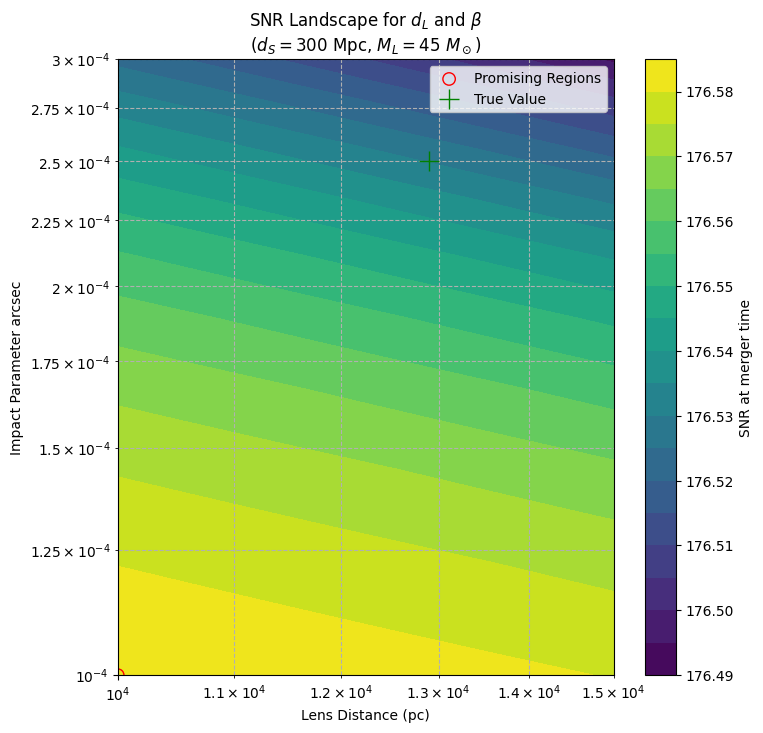

In [ ]:
# --- 4. PLOT THE 2D HEATMAPS WITH PROMISING POINTS OVERLAID ---

fig, ax = pylab.subplots(figsize=[8, 8])
'''
finite_mask = np.isfinite(max_snr_grid)
min_chi_squared = chi_squared_grid[finite_mask]
min_chi_squared = min_chi_squared.reshape(dl_grid.shape)
#delta_chi_squared = chi_squared_grid - min_chi_squared

#delta_chi_squared = chi_squared_grid - min_chi_squared

#delta_chi_squared_masked = np.ma.masked_invalid(min_chi_squared)
'''
# Plot
#vmin = delta_chi_squared_masked.min()
im2 = pylab.contourf(dl_grid , beta_grid ,max_snr_grid, levels=20, cmap = 'viridis')
fig.colorbar(im2, ax=ax, label='SNR at merger time')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Lens Distance (pc)')
ax.set_ylabel('Impact Parameter arcsec')
pylab.grid(True, which="both", ls="--")
title_str = (f'SNR Landscape for $d_L$ and $\\beta$\n'
             f'($d_S={fixed_ds_pc/1e6:.0f}$ Mpc, $M_L={fixed_lens_mass:.0f}$ $M_\\odot$)')
ax.set_title(title_str)


# Overlay the promising points on both plots
if len(promising_dl) > 0:

   ax.scatter(promising_dl , promising_beta ,
                facecolors='none', edgecolors='r', s=80, label='Promising Regions')
   ax.plot(true_dl_pc, true_beta_arcsec, 'g+', markersize=15, label='True Value')
   ax.legend()

pylab.show()

With much more noise


Optimal SNR of the injected signal: 60.33

Simulated data created

Calculating true observables from injected parameters...
--- Setting up 2D Slice Analysis ---
Calculating chi-squared for 25 grid points using 18 cores...


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Calculation complete.


--- Filtering Grid to Find Promising MCMC Starting Points ---
Max SNR value: 3.898948
Found 1 promising parameter combinations.

These parameter sets can now be used to initialize MCMC walkers:

Top 10 best parameter combinations:
  1. dl = 100000000.00 pc, beta = 2.50e-01 arcsec, chi² = 3.898948

Best point to start MCMC:
  dl   = 100000000.00 pc
  beta = 2.50e-01 arcsec
  ds   = 300 Mpc (fixed)
  M    = 45 M_sun (fixed)
  chi² = 3.898948


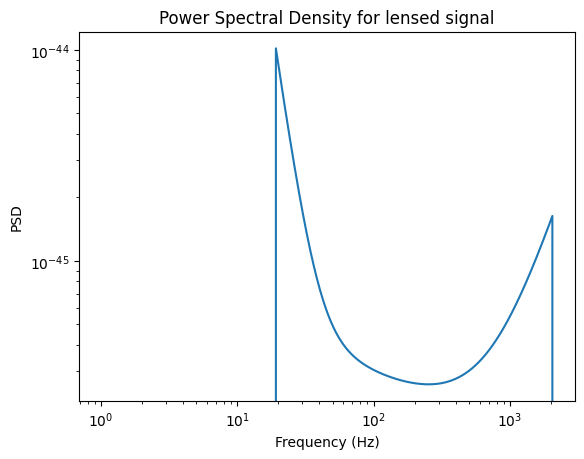

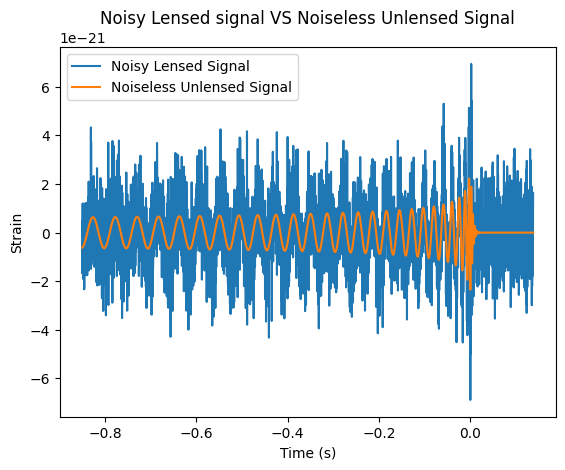

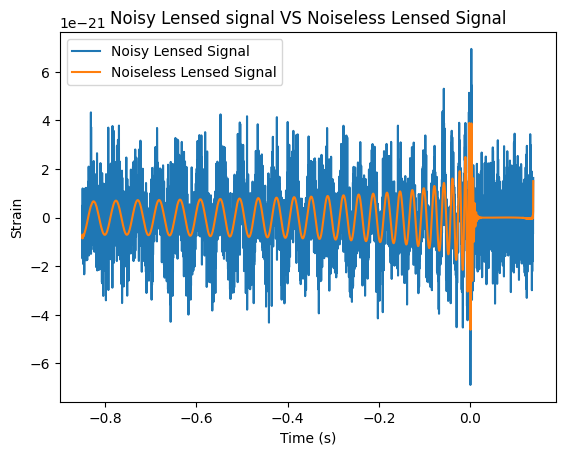

In [ ]:
if __name__ == "__main__":

    # ---1. First, we create our lensed data ---

    true_mass_lens = 45 #solar_masses
    true_dl_pc = 12897 #pc
    true_ds_pc = 300 #Mpc
    true_beta_arcsec = 2.5e-4

    hp_unlensed,_ = get_td_waveform(approximant='SEOBNRv3',
                             mass1=30,
                             mass2=30,
                             delta_t=1.0/4096,
                             f_lower=20,
                             distance = true_ds_pc)


    # 2. Calculate the amplification in the wave optic regime
    true_mass_lens_kg = true_mass_lens*solar_mass_kg #kg
    true_dl_m = (12897*u.pc).to(u.m).value #m
    true_ds_m = (300e6*u.pc).to(u.m).value #m
    true_beta_rad = (2.5e-4*u.arcsec).to(u.rad).value #rad

    hp_unlensed_freq = hp_unlensed.to_frequencyseries()
    frequency_array_template = np.array(hp_unlensed_freq.sample_frequencies)
    true_einstein_rad = einstein_radius_calc(true_mass_lens_kg,true_ds_m,true_dl_m)
    true_F_f = calculate_amplification_factor(frequency_array_template,true_mass_lens_kg,true_dl_m,true_beta_rad,true_einstein_rad)

    # 3. Apply the magnification
    hp_lensed_freq = hp_unlensed_freq * true_F_f
    hp_lensed = hp_lensed_freq.to_timeseries()
    hp_lensed = resample_to_delta_t(highpass(hp_lensed,10),1./4096)  #Warning, this induce artifacts at end end begininng but I don't think it is problematic as we'll focus at merger time
    hp_lensed.crop(0.1,0.1)

    # 4. Generate realistic noise
    delta_f = 1/hp_lensed.duration
    flen = len(hp_lensed)//2 + 1
    f_low = 20
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low) * 20 #PSD ~ A**2
    freqs = psd.sample_frequencies
    psd_data = psd.data
    delta_t = 1.0 / 4096
    noise_len = len(hp_lensed)
    noise = pycbc.noise.noise_from_psd(noise_len, delta_t, psd, seed=150)
    noise_timeseries = TimeSeries(noise, delta_t= delta_t, epoch = hp_lensed.start_time) #bruit plotté à partir de t = 0 -> need a shift in h_plus

    # 5. Inject noise into the lensed signal. This is our data
    data = hp_lensed + noise_timeseries
    pylab.figure()
    pylab.loglog(freqs,psd)
    pylab.xlabel('Frequency (Hz)')
    pylab.ylabel('PSD')
    pylab.title('Power Spectral Density for lensed signal')
    pylab.figure()
    pylab.plot(data.sample_times,data, label = "Noisy Lensed Signal")
    pylab.plot(hp_unlensed.sample_times,hp_unlensed, label = "Noiseless Unlensed Signal")
    pylab.xlabel('Time (s)')
    pylab.ylabel('Strain')
    pylab.legend()
    pylab.title('Noisy Lensed signal VS Noiseless Unlensed Signal')
    pylab.figure()
    pylab.plot(data.sample_times,data, label = "Noisy Lensed Signal")
    pylab.plot(hp_lensed.sample_times,hp_lensed, label = "Noiseless Lensed Signal")
    pylab.xlabel('Time (s)')
    pylab.ylabel('Strain')
    pylab.legend()
    pylab.title('Noisy Lensed signal VS Noiseless Lensed Signal')



    psd_data = interpolate(psd,data.to_frequencyseries().delta_f)
    psd_data.resize(len(data))
    valid_indices = psd_data > 0
    delta_f = hp_lensed_freq.delta_f

    snr_series_best = matched_filter(data,data,psd=psd_data,low_frequency_cutoff=20,high_frequency_cutoff=1024)
    snr_array_best = np.array(snr_series_best)

    max_snr_best = np.max(np.abs(snr_array_best))

    print(f"\nOptimal SNR of the injected signal: {max_snr_best:.2f}\n")

    print ("Simulated data created\n")

    # --- 0. CALCULATE THE TRUE OBSERVABLES TO SEARCH FOR ---
    print("Calculating true observables from injected parameters...")
    # a. Define the fixed parameters
    fixed_ds_pc = true_ds_pc*1e6 # Source distance in Mpc
    fixed_lens_mass = true_mass_lens # Lens mass in Solar Masses



    # Get the noisy data in the frequency domain
    hp_unlensed_template = hp_unlensed.copy()
    hp_unlensed_template.resize(len(data))
    hp_unlensed_freq_template = hp_unlensed_template.to_frequencyseries()
    data_freq = data.to_frequencyseries()


    from pycbc.types import FrequencySeries
    hp_unlensed_freq_template = FrequencySeries(
        hp_unlensed_freq_template.data,
        delta_f=data_freq.delta_f,  # Force same delta_f for divison between frequency_series
        epoch=hp_unlensed_freq_template.epoch)

    #We can also do a noise weighted chisquared. It will be considered into the MCMC but this is not harmfull to already consider it
    #we need to resize the psd for this
    new_psd = interpolate(psd, data_freq.delta_f)
    new_psd.resize(len(data_freq))

    #We don't focus on the dt or group delay or magnification, we directly compare the F_f curves as it contains the amplification AND the phase


    # --- 1. SETUP THE 2D SLICE ANALYSIS ---

    print("--- Setting up 2D Slice Analysis ---")

    # b. Create the 2D grid for the parameters we want to vary
    n_points = 5
    dl_pc_range = np.linspace(1, 1e8, n_points) # 10 kpc to 10 Mpc
    beta_arcsec_range = np.linspace(1e-8, 1, n_points) # 0.01 to 1 milli-arcsec



    dl_grid, beta_grid = np.meshgrid(dl_pc_range, beta_arcsec_range, indexing='ij')



    # --- 2. PARALLEL CALCULATION OF THE GRID ---
    print(f"Calculating chi-squared for {n_points*n_points} grid points using 18 cores...")
    fixed_ds_m = (true_ds_pc * 1e6 * u.pc).to(u.m).value
    fixed_mass_kg = true_mass_lens * solar_mass_kg
    params_list = list(zip(dl_grid.flatten(), beta_grid.flatten()))

    worker_func = partial(calculate_chi_squared_for_point,
                          fixed_mass_kg=fixed_mass_kg,
                          fixed_ds_m=fixed_ds_m,
                          hp_unlensed_freq_template=hp_unlensed_freq_template,
                          data_freq=data_freq,
                          #data=data,
                          new_psd=new_psd)

    with multiprocessing.Pool(processes=18) as pool:
        results = list(tqdm(pool.imap(worker_func, params_list), total=len(params_list)))
    max_snr_grid = []
    for r in results:
      max = np.max(np.abs(r))
      max_snr_grid.append(max)


    max_snr_grid = np.array(max_snr_grid)
    max_snr_grid = max_snr_grid.reshape(dl_grid.shape)
    print("Calculation complete.\n")

    # --- 3. FILTER RESULTS TO FIND PROMISING PARAMETERS FOR MCMC ---
    print("\n--- Filtering Grid to Find Promising MCMC Starting Points ---")

    # a. Define chi_squared tolerance range

    #min_chi_squared = np.nanmin(chi_squared_grid)

    max_snr = np.nanmax(max_snr_grid)
    print(f"Max SNR value: {max_snr:.6f}")



    # b. Create masks to find where the grid values fall within the target ranges ==> We will have chi_squared~0
    SNR_mask = max_snr_grid == max_snr

    # c. Combine masks to find points that satisfy chi_squared condition
    promising_indices = np.where(SNR_mask)

    # d. Extract the dl and beta values from these promising points
    promising_dl = dl_grid[promising_indices]
    promising_beta = beta_grid[promising_indices]
    promising_SNR= max_snr_grid[promising_indices]



    print(f"Found {len(promising_dl)} promising parameter combinations.")

    if len(promising_dl) > 0:

        # Sort by chi-squared value to find the best candidates
        sort_indices = np.argsort(promising_SNR)[::-1]
        promising_dl = promising_dl[sort_indices]
        promising_beta = promising_beta[sort_indices]
        promising_SNR = promising_SNR[sort_indices]
        print("\nThese parameter sets can now be used to initialize MCMC walkers:")
        # We now have the dl and beta. The ds and mass were fixed.
        # We can create the full parameter set for MCMC.
        promising_ds = np.full_like(promising_dl, fixed_ds_pc)
        promising_mass = np.full_like(promising_dl, fixed_lens_mass)
        print("\nTop 10 best parameter combinations:")
        for k in range(min(10, len(promising_dl))):
            print(f"  {k+1}. dl = {promising_dl[k]:.2f} pc, beta = {promising_beta[k]:.2e} arcsec, chi² = {promising_SNR[k]:.6f}")

        print(f"\nBest point to start MCMC:")
        print(f"  dl   = {promising_dl[0]:.2f} pc")
        print(f"  beta = {promising_beta[0]:.2e} arcsec")
        print(f"  ds   = {fixed_ds_pc/1e6:.0f} Mpc (fixed)")
        print(f"  M    = {fixed_lens_mass:.0f} M_sun (fixed)")
        print(f"  chi² = {promising_SNR[0]:.6f}")


        '''

        #Extraction with promising set of parameters
        snr_extr = max_snr_grid[promising_indices]
        peak = np.argmax(abs(snr_extr))
        snrp = snr_series[peak]
        timepeak = snr_series.sample_times[peak]

        dt = timepeak - data.start_time
        aligned = h_lensed_template.cyclic_time_shift(dt)

        aligned /= sigma(aligned, psd=new_psd, low_frequency_cutoff = 15.0)
        aligned = (aligned.to_frequencyseries()*snrp).to_timeseries()
        aligned.start_time = data.start_time

        white_data = (data_freq/new_psd**0.5).to_timeseries()
        tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)#filter

        white_template = (tapered.to_frequencyseries() / new_psd**0.5).to_timeseries()
        white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
        white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

        _,t = white_template.max_loc() #we localise the sample where the SNR is maximum (and so where we have the merger)
        '''


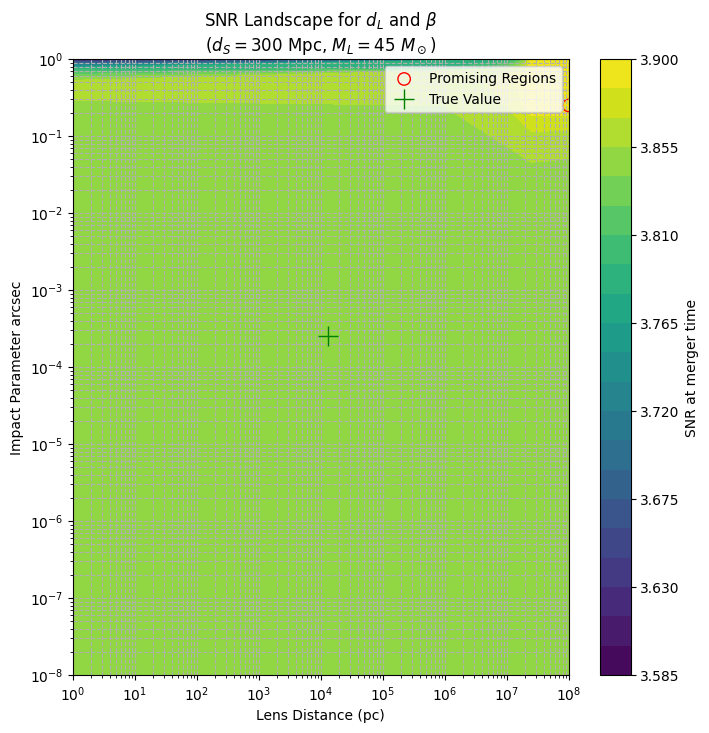

In [ ]:
# --- 4. PLOT THE 2D HEATMAPS WITH PROMISING POINTS OVERLAID ---

fig, ax = pylab.subplots(figsize=[8, 8])
'''
finite_mask = np.isfinite(max_snr_grid)
min_chi_squared = chi_squared_grid[finite_mask]
min_chi_squared = min_chi_squared.reshape(dl_grid.shape)
#delta_chi_squared = chi_squared_grid - min_chi_squared

#delta_chi_squared = chi_squared_grid - min_chi_squared

#delta_chi_squared_masked = np.ma.masked_invalid(min_chi_squared)
'''
# Plot
#vmin = delta_chi_squared_masked.min()
im2 = pylab.contourf(dl_grid , beta_grid ,max_snr_grid, levels=20, cmap = 'viridis')
fig.colorbar(im2, ax=ax, label='SNR at merger time')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Lens Distance (pc)')
ax.set_ylabel('Impact Parameter arcsec')
pylab.grid(True, which="both", ls="--")
title_str = (f'SNR Landscape for $d_L$ and $\\beta$\n'
             f'($d_S={fixed_ds_pc/1e6:.0f}$ Mpc, $M_L={fixed_lens_mass:.0f}$ $M_\\odot$)')
ax.set_title(title_str)


# Overlay the promising points on both plots
if len(promising_dl) > 0:

   ax.scatter(promising_dl , promising_beta ,
                facecolors='none', edgecolors='r', s=80, label='Promising Regions')
   ax.plot(true_dl_pc, true_beta_arcsec, 'g+', markersize=15, label='True Value')
   ax.legend()

pylab.show()